Using Fox-Li method to determine fundamental mode of near-concentric resonator,
including mirror distortionts.

The Fox-Li method is described in their publication FoxLi1961.

Using the `poppy` package and its `FresnelWavefront` class, which implements Fresnel diffraction
using 2D FFT.

FoxLi1961:
Fox, A. G., and Tingye Li. “Resonant Modes in a Maser Interferometer.” The Bell System Technical Journal 40, no. 2 (March 1961): 453–88. https://doi.org/10.1002/j.1538-7305.1961.tb01625.x.

In [64]:
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import scipy.optimize
import logging

import gaussian_beam

In [57]:
import imp
imp.reload(gaussian_beam)

C:\Users\Lothar\AppData\Local\Temp\ipykernel_31880\2194754041.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'gaussian_beam' from 'c:\\Users\\Lothar\\Dropbox (Personal)\\MPQ\\HLab\\Projects\\2S-nP collimator\\Diffraction calculation\\gaussian_beam.py'>

In [58]:
logging.basicConfig()
logger = logging.getLogger()
# Switch on debug output of poppy (containing information on which algorithms are used)
# logger.setLevel(logging.DEBUG)
# Switch off debug output of poppy
logger.setLevel(logging.INFO)

In [59]:
def add_wavefront_curvature(wf, roc):
    """Add wavefront curvature with radius of curvature of `roc` to poppy field `wf`."""
    Y, X = wf.coordinates()
    wf.wavefront *= np.exp(1j*np.pi/wf.wavelength.to('m').value/roc.to('m').value*(X**2+Y**2))
    return wf

gaussian_profile_1d = lambda x, w: np.exp(-x**2/w**2)    

0.18453904215165604 m
0.00025 m


Text(0.5, 0.98, 'Entrance Pupil')

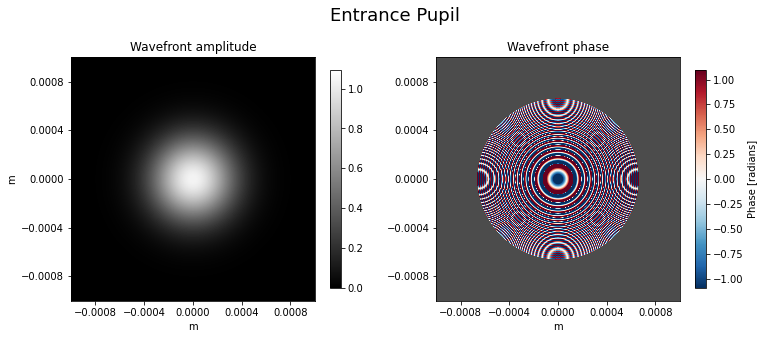

In [136]:
# Oversampling, i.e., factor by which sample size will be increased
# to suppress FFT artifacts
num_oversample = 4
# Number of iterations of Fox-Li method
num_iter = 1000
# Save results from every `delta_iter_saved`-th iteration
delta_iter_saved = 100
# Wavelength
wavelength = 1064*u.nm

aperture_func = None
wavefront_curvature_func = None
initial_wavefront_roc = None

# # Spherical mirrors
# # Number of pixels in sample
# num_pixels = 512
# # Aperture radius
# aperture_radius = 2*u.mm
# # Propagation distance
# z = 0.1*u.m
# # Mirror ROC (negative ROC corresponds to concave mirrors)
# roc = -4*u.m
# # Aperture function
# aperture_func = poppy.CircularAperture(radius=aperture_radius)
# wavefront_curvature_func = lambda wf: add_wavefront_curvature(wf, roc/2)
# # Physical sample size (full width)
# sample_size = aperture_radius
# # Start beam profile
# initial_gaussian_radius = 400*u.um
# initial_wavefront_roc = roc

# Spherical mirrors
# Number of pixels in sample
num_pixels = 1024
# Aperture radius
aperture_radius = 0.5*u.mm
# Propagation distance
z = 20*u.mm-13*u.um
# Mirror ROC (negative ROC corresponds to concave mirrors)
roc = -10*u.mm
# Aperture function
# aperture_func = poppy.CircularAperture(radius=aperture_radius)
aperture_func = None
wavefront_curvature_func = lambda wf: add_wavefront_curvature(wf, -roc/2)
# Physical sample size (full width)
sample_size = aperture_radius
# Start beam profile
# initial_gaussian_radius = 364*u.um
initial_gaussian_radius = 341*u.um
initial_wavefront_roc = roc

num_oversamples = num_pixels*num_oversample
ind_c = num_oversamples//2
oversample_size = sample_size*num_oversample
x = np.arange(num_oversamples)/(num_oversamples)*oversample_size-oversample_size/2
hroundtrips = np.arange(num_iter+1)
ind_iters_saved = np.arange(0, num_iter+1)[::delta_iter_saved]

# Empty arrays
wavefront_cuts = np.zeros((num_iter+1, num_oversamples), dtype=np.complex128)
wavefronts = np.zeros(
    (len(ind_iters_saved), num_oversamples, num_oversamples), dtype=np.complex128)

# Initial field
wf = poppy.FresnelWavefront(
    sample_size/2, wavelength=wavelength,
    npix=num_pixels, oversample=num_oversample)

# Set-up Gaussian beam with given radius and wavefront curvature
beam = gaussian_beam.GaussianBeam(
    q=0,    
    wavelength=wavelength.to('m').value,
    w0=initial_gaussian_radius.to('m').value
    )
beam.roc = initial_wavefront_roc.to('m').value
Y, X = wf.coordinates()
wf.wavefront = beam.laguerre_gauss(0, 0, np.sqrt(X**2+Y**2), np.arctan2(Y, X))
wf.wavefront /= np.abs(wf.wavefront.max())
wf.wavefront = wf.wavefront.astype(np.complex128)

# Step-function phase mask along x-axis
# wf.wavefront[:, ind_c:] *= -1
if aperture_func is not None:
    wf *= aperture_func

print(wf.z_r.to('m'))
print(wf.w_0.to('m'))

wavefront_cuts[0] = wf.wavefront[ind_c, :]
wf_initial = wf.copy()
wavefronts[0] = wf.wavefront

plt.figure(figsize=(12,5))
wf.display('both', colorbar=True, showpadding=True)
plt.suptitle("Entrance Pupil", fontsize=18)

In [6]:
# wf.propagate_fresnel(z/2)

In [7]:
# roc = -2*u.m
# wf = add_wavefront_curvature(wf, roc)

In [8]:
# if aperture_func is not None:
#     wf *= aperture_func

In [9]:
# if wavefront_curvature_func is not None:
#     wf = wavefront_curvature_func(wf)

C:\Users\Lothar\AppData\Local\Temp\ipykernel_31880\2274714563.py:2: RuntimeWarning: divide by zero encountered in log
  mirror_dist = lambda r, w, roc: w**2/4*np.log(r/roc)-w**2/8*scipy.special.expi(-2*r**2/w**2)
C:\Users\Lothar\AppData\Local\Temp\ipykernel_31880\2274714563.py:2: RuntimeWarning: invalid value encountered in subtract
  mirror_dist = lambda r, w, roc: w**2/4*np.log(r/roc)-w**2/8*scipy.special.expi(-2*r**2/w**2)


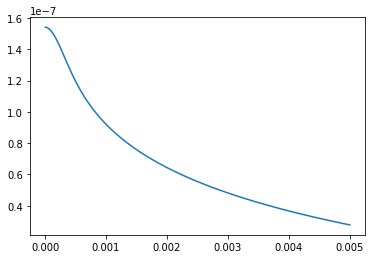

In [95]:
import scipy.special
mirror_dist = lambda r, w, roc: w**2/4*np.log(r/roc)-w**2/8*scipy.special.expi(-2*r**2/w**2)
rs = np.linspace(0, 5e-3, 1000)
plt.plot(
    rs, -mirror_dist(rs, 400e-6, 10e-3))

In [11]:
# Y, X = wf.coordinates()
# X += 1e-9
# Y += 1e-9
# uz = lambda r: mirror_dist(r, 400e-6, 10e-3)/4
# # print(np.sum(np.isnan(uz(np.sqrt(X**2+Y**2)))))
# wf.wavefront *= np.exp(1j*2*np.pi/wf.wavelength.to('m').value*uz(np.sqrt(X**2+Y**2)))

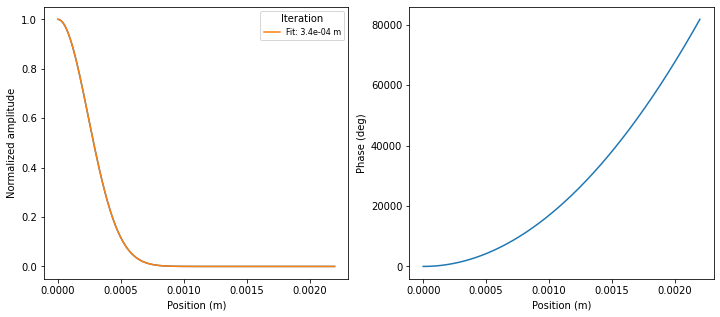

In [111]:
# Field amplitude and phase
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = axs[0]
_, X = wf.coordinates()
mask = (x >= 0) & (x <= 1.1*aperture_radius)

# Field amplitude
y = np.abs(wf.wavefront[ind_c, mask])
# Intensity
# y = np.abs(wf.wavefront[ind_c, mask])**2
# Fit 1D Gaussian
pstart = [np.sqrt(np.sum(x[mask]**2*y)/np.sum(y)).to('m').value]
popt, pcov = scipy.optimize.curve_fit(
    gaussian_profile_1d, x[mask].to('m').value, y/y.max(), pstart)        
axs[0].plot(
    x[mask].to('m').value, y/y.max())
axs[0].plot(
    x[mask].to('m').value, gaussian_profile_1d(x[mask].to('m').value, *popt),
    label=f'Fit: {popt[0]:.1e} m')

# Phase of electric field (relative to value at origin)
y = np.rad2deg((np.unwrap(np.angle(wf.wavefront[ind_c, mask]))))
axs[1].plot(
    x[mask].to('m').value, y-y[0])

for ax in axs:
    ax.set_xlabel(r'Position (m)')
axs[0].set_ylabel('Normalized amplitude')
axs[1].set_ylabel('Phase (deg)')
axs[0].legend(title='Iteration', loc='best', fontsize=8)

In [98]:
def decompose_into_lg_modes(beam, field, r, p_max=100):
    """
    Decompose electric field `field` of radially symmetric beam, sampled at radial points `r`, into
    Laguerre-Gauss modes with the fundamental mode given by `beam`.

    p_max : int
        Max. value of radial mode index `p` of Laguerre-Gauss modes to include.
    """

    # Normalize calculated beam
    field_norm_const = np.sqrt(scipy.integrate.trapezoid(2*np.pi*r*field*np.conjugate(field), r))
    field /= field_norm_const

    ps = np.arange(0, p_max+1)
    coeffs = np.zeros(p_max+1, dtype=np.complex128)
    for p in range(p_max+1):
        mode = beam.laguerre_gauss(p, 0, r, 0)
        # Calculate overlap
        coeffs[p] = scipy.integrate.trapezoid(2*np.pi*r*field*np.conjugate(mode), r)

    return ps, coeffs

1.09e-05


Text(0, 0.5, 'Phase (rad)')

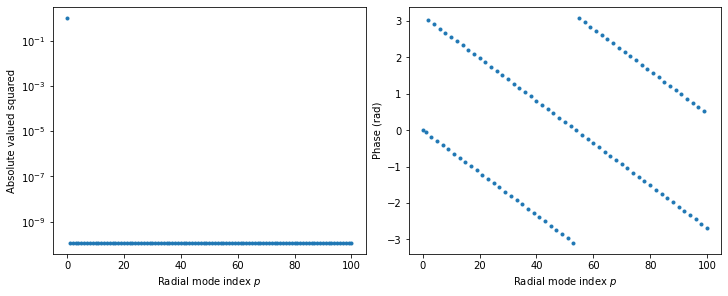

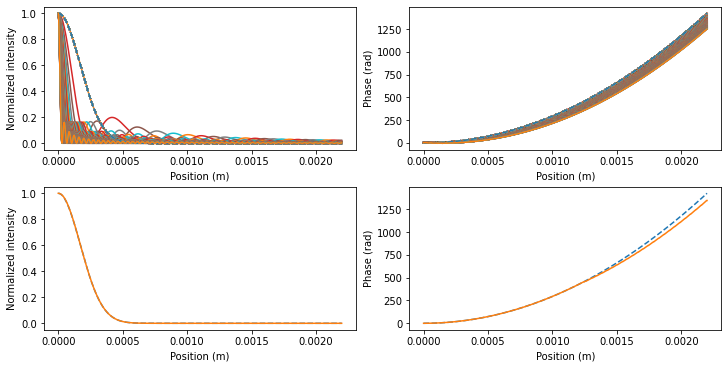

In [99]:
# Find decomposition of calculated beam into Laguerre-Gauss modes

# Max. value of radial mode index `p` of Laguerre-Gauss modes to include
p_max = 100

mask = (x >= 0) & (x <= 1.1*sample_size)
r = x[mask].to('m').value

# Calculated beam
wf_calc = wf.copy()
calc = wf_calc.wavefront[ind_c, mask]

ps, coeffs = decompose_into_lg_modes(beam, calc, r, p_max)

# print(coeffs)
# print(np.abs(coeffs)**2)
print(f'{1-np.sum(np.abs(coeffs)**2):.2e}')

# Plot mode decomposition
fig, axs = plt.subplots(1, 2, num='Mode decomposition', figsize=(10, 4), constrained_layout=True)
linestyle = {'marker': 'o', 'linestyle': '', 'markersize': 3}    
axs[0].plot(ps, np.abs(coeffs)**2, **linestyle)
axs[1].plot(ps, np.angle(coeffs), **linestyle)
axs[0].set_yscale('log')
for ax in axs:
    ax.set_xlabel(r'Radial mode index $p$')
axs[0].set_ylabel(r'Absolute valued squared')    
axs[1].set_ylabel(r'Phase (rad)')

# Plot mode reconstruction
# Position relative to beam waist at which reconstruction is shown
beam_ = copy.copy(beam)
coeffs_ = coeffs.copy()
z_ = 0.*beam_.zr

# # M2 configuration
# f_m2 = 1*u.m
# abcd = abcd_thin_lens(f_m2.to('m').value)
# beam_.apply_abcd(abcd)
# # Calculate decomposition coefficients of beam after M2 lens by adding additional Gouy phase of
# # of Laguerre-Gauss modes from M2 lens to coefficents of beam before M2 lens
# coeffs_ = [coeff*np.exp(-1j*(2*p+1)*beam_.psi) for p, coeff in zip(ps, coeffs)]
# z_ = f_m2.to('m').value+2.*beam_.zr

q_ = beam_.q+z_
reconst = np.sum(
    [coeff*beam_.laguerre_gauss(p, 0, r, 0, q=q_) for p, coeff in zip(ps, coeffs_)], axis=0)

fig, axs = plt.subplots(2, 2, num='Mode reconstruction', figsize=(10, 5), constrained_layout=True)
# Mode
for p in ps:
    mode = coeffs[p]*beam.laguerre_gauss(p, 0, r, 0, q=beam.q)
    axs[0, 0].plot(
        r, np.abs(calc)**2/np.max(np.abs(calc)**2), linestyle='--',
        )
    axs[0, 0].plot(
        r, np.abs(mode)**2/np.max(np.abs(mode)**2),
        ) 
    axs[0, 1].plot(
        r, np.unwrap(np.angle(calc)), linestyle='--',
        )
    axs[0, 1].plot(
        r, np.unwrap(np.angle(mode)),
        )

axs[1, 0].plot(
    r, np.abs(calc)**2/(np.abs(calc)**2).max(), linestyle='--',
    )
axs[1, 0].plot(
    r, np.abs(reconst)**2/(np.abs(reconst)**2).max(),
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(calc)), linestyle='--',
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(reconst)),
    )
for ax in axs.flatten():
    ax.set_xlabel('Position (m)')
axs[0, 0].set_ylabel('Normalized intensity')
axs[0, 1].set_ylabel('Phase (rad)')
axs[1, 0].set_ylabel('Normalized intensity')
axs[1, 1].set_ylabel('Phase (rad)')

In [137]:
# Propagate over cavity length `z`, add quadratic mirror curvature, add mirror distortion,
# add aperture function, repeat, using mode decomposition.

intensity_norm = np.abs(wavefronts[0])**2/(np.abs(wavefronts[0])**2).max()
Y, X = wf.coordinates()
# Max. value of radial mode index `p` of Laguerre-Gauss modes to include
p_max = 100

mask = (x >= 0) & (x <= 1.1*sample_size)
r = x[mask].to('m').value

# Calculated beam
wf_calc = wf_initial.copy()
calc = wf_calc.wavefront[ind_c, mask]

wavefront_cuts_decomp = np.zeros((num_iter+1, len(r)), dtype=np.complex128)
wavefront_cuts_decomp[0] = calc

intensity_norm = np.abs(calc)**2/(np.abs(calc)**2).max()
for i in range(1, num_iter+1):

    ps, coeffs = decompose_into_lg_modes(beam, calc, r, p_max)

    reconst = np.sum([
        coeff*beam.laguerre_gauss(p, 0, r, 0, q=beam.q+z.to('m').value)
        for p, coeff in zip(ps, coeffs)], axis=0)

    # Add quadratic mirror curvature
    reconst *= np.exp(1j*np.pi/wf.wavelength.to('m').value*(-2/roc.to('m').value)*r**2)

    # Add mirror distortion
    uz = lambda r: mirror_dist(r, 400e-6, 10e-3)
    reconst *= np.exp(-1j*2*np.pi/wf.wavelength.to('m').value*uz(r+1e-9))

    # Add aperture
    mask_aper = r <= aperture_radius.to('m').value
    reconst[~mask_aper] = 0.

    wavefront_cuts_decomp[i] = reconst

    calc = reconst

    intensity_norm_ = np.abs(reconst)**2
    intensity_norm_ /= intensity_norm_.max()
    max_diff = np.nanmax((intensity_norm_-intensity_norm)/intensity_norm_)
    intensity_norm = intensity_norm_
    print(f'Iteration {i:d}: Max. norm. int. change of {max_diff:.1e} from previous iter.')

C:\Users\Lothar\AppData\Local\Temp\ipykernel_31880\2007310718.py:45: RuntimeWarning: divide by zero encountered in true_divide
  max_diff = np.nanmax((intensity_norm_-intensity_norm)/intensity_norm_)
C:\Users\Lothar\AppData\Local\Temp\ipykernel_31880\2007310718.py:45: RuntimeWarning: invalid value encountered in true_divide
  max_diff = np.nanmax((intensity_norm_-intensity_norm)/intensity_norm_)


Iteration 1: Max. norm. int. change of 1.2e-01 from previous iter.
Iteration 2: Max. norm. int. change of 9.7e-02 from previous iter.
Iteration 3: Max. norm. int. change of 2.0e-01 from previous iter.
Iteration 4: Max. norm. int. change of 1.1e-01 from previous iter.
Iteration 5: Max. norm. int. change of 8.5e-02 from previous iter.
Iteration 6: Max. norm. int. change of 3.0e-01 from previous iter.
Iteration 7: Max. norm. int. change of 1.3e-01 from previous iter.
Iteration 8: Max. norm. int. change of 8.6e-02 from previous iter.
Iteration 9: Max. norm. int. change of 1.2e-01 from previous iter.
Iteration 10: Max. norm. int. change of 6.4e-02 from previous iter.
Iteration 11: Max. norm. int. change of 0.0e+00 from previous iter.
Iteration 12: Max. norm. int. change of 3.5e-02 from previous iter.
Iteration 13: Max. norm. int. change of 6.6e-01 from previous iter.
Iteration 14: Max. norm. int. change of 4.8e-01 from previous iter.
Iteration 15: Max. norm. int. change of 7.9e-02 from prev

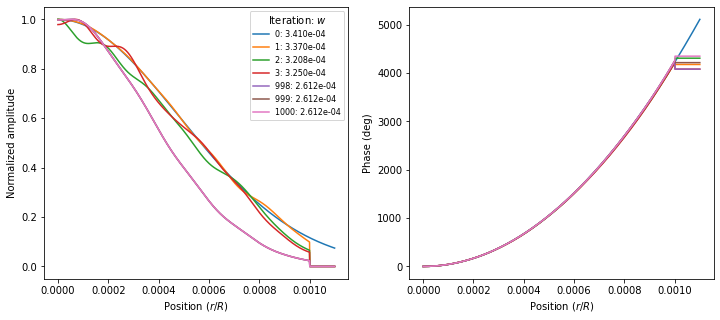

In [138]:
# Field amplitude and phase at different iterations
# for solution using mode decomposition
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = axs[0]
for i in [0, 1, 2, 3, num_iter-2, num_iter-1, num_iter]:
# for i in np.arange(80, num_iter+1):
# for i in np.arange(0, num_iter+1):
# for i, j in enumerate(ind_iters_saved):
    # Field amplitude
    # y = np.abs(wavefronts[i, ind_c, mask])
    y = np.abs(wavefront_cuts_decomp[i])
    # Fit 1D Gaussian
    pstart = [np.sqrt(np.sum(r**2*y)/np.sum(y))]
    popt, pcov = scipy.optimize.curve_fit(
        gaussian_profile_1d, r, y/y.max(), pstart)    
    axs[0].plot(
        r/aperture_radius, y/y.max(),
        label=f'{i}: {popt[0]:.3e}')

    # Phase of electric field (relative to value at origin)
    # y = np.rad2deg(np.unwrap(np.angle(wavefronts[i, ind_c, mask])))
    y = np.rad2deg(np.unwrap(np.angle(wavefront_cuts_decomp[i])))    
    axs[1].plot(
        r/aperture_radius, y-y[0])
for ax in axs:
    ax.set_xlabel(r'Position ($r/R$)')
axs[0].set_ylabel('Normalized amplitude')
axs[1].set_ylabel('Phase (deg)')
axs[0].legend(title=r'Iteration: $w$', loc='best', fontsize=8)

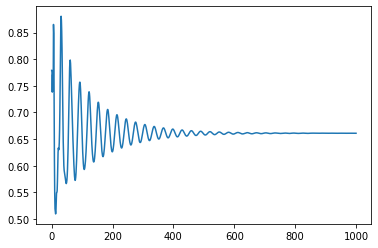

In [139]:
# Flucutation of normalized field amplitude at (x, y) position `(initial_gaussian_radius/2, 0)`
# as a function of number of iterations,
# for solution using mode decomposition
x_c = initial_gaussian_radius/2
mask = hroundtrips > -1
ax = plt.gca()
ax.plot(
    np.arange(num_iter+1)[mask],
    np.abs(wavefront_cuts_decomp[mask, np.argmin(np.abs(r-x_c.to('m').value))])
    /np.abs(wavefront_cuts_decomp[mask, 0])
    )

In [104]:
intensity_norm = np.abs(wavefronts[0])**2/(np.abs(wavefronts[0])**2).max()
Y, X = wf.coordinates()
# X += 1e-9
# Y += 1e-9
for i in range(1, num_iter+1):

    # Using internal poppy function that just propagates using FFT.
    # Do *not* use `wf_m2.propagate_fresnel`, as this will result in wrong results as poppy applies
    # some magic, assuming you want to propagate directly to the Fourier plane.
    # Note that the sign of the propagation distance is reversed in this case.    
    wf._propagate_ptp(-z)

    if aperture_func is not None:
        wf *= aperture_func
    if wavefront_curvature_func is not None:
        wf = wavefront_curvature_func(wf)

    # Add mirror distortion
    uz = lambda r: mirror_dist(r, 400e-6, 10e-3)
    wf.wavefront *= np.exp(-1j*2*np.pi/wf.wavelength.to('m').value*uz(np.sqrt(X**2+Y**2)+1e-9))    

    wavefront_cuts[i] = wf.wavefront[ind_c, :]
    if i in ind_iters_saved:
        j = (np.repeat(ind_iters_saved, delta_iter_saved)/delta_iter_saved).astype(int)[i]
        wavefronts[j] = wf.wavefront.copy()

    intensity_norm_ = np.abs(wf.wavefront)**2
    intensity_norm_ /= intensity_norm_.max()
    max_diff = np.nanmax((intensity_norm_-intensity_norm)/intensity_norm_)
    intensity_norm = intensity_norm_
    print(f'Iteration {i:d}: Max. norm. int. change of {max_diff:.1e} from previous iter.') 

C:\Users\Lothar\AppData\Local\Temp\ipykernel_31880\3616262656.py:25: RuntimeWarning: divide by zero encountered in true_divide
  max_diff = np.nanmax((intensity_norm_-intensity_norm)/intensity_norm_)


Iteration 1: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 2: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 3: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 4: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 5: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 6: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 7: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 8: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 9: Max. norm. int. change of 1.0e+00 from previous iter.
Iteration 10: Max. norm. int. change of 1.0e+00 from previous iter.


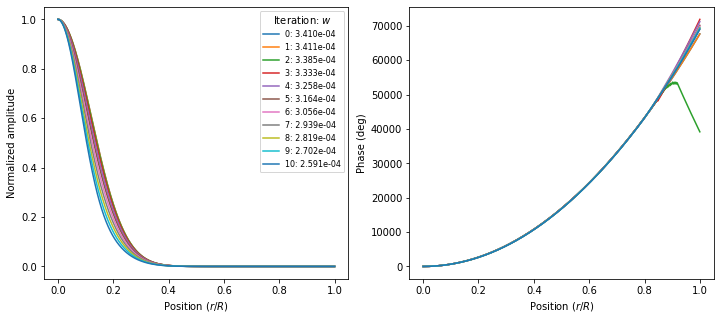

In [105]:
# Field amplitude and phase at different iterations
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = axs[0]
_, X = wf.coordinates()
mask = (x >= 0) & (x <= 1.*aperture_radius)
# for i in [0, 1, 2, 3, num_iter-2, num_iter-1, num_iter]:
# for i in np.arange(80, num_iter+1):
for i in np.arange(0, num_iter+1):
# for i, j in enumerate(ind_iters_saved):
    # Field amplitude
    # y = np.abs(wavefronts[i, ind_c, mask])
    y = np.abs(wavefront_cuts[i, mask])
    # Fit 1D Gaussian
    pstart = [np.sqrt(np.sum(x[mask]**2*y)/np.sum(y)).to('m').value]
    popt, pcov = scipy.optimize.curve_fit(
        gaussian_profile_1d, x[mask].to('m').value, y/y.max(), pstart)    
    axs[0].plot(
        x[mask]/aperture_radius, y/y.max(),
        label=f'{i}: {popt[0]:.3e}')

    # Phase of electric field (relative to value at origin)
    # y = np.rad2deg(np.unwrap(np.angle(wavefronts[i, ind_c, mask])))
    y = np.rad2deg(np.unwrap(np.angle(wavefront_cuts[i, mask])))    
    axs[1].plot(
        x[mask]/aperture_radius, y-y[0])
for ax in axs:
    ax.set_xlabel(r'Position ($r/R$)')
axs[0].set_ylabel('Normalized amplitude')
axs[1].set_ylabel('Phase (deg)')
axs[0].legend(title=r'Iteration: $w$', loc='best', fontsize=8)

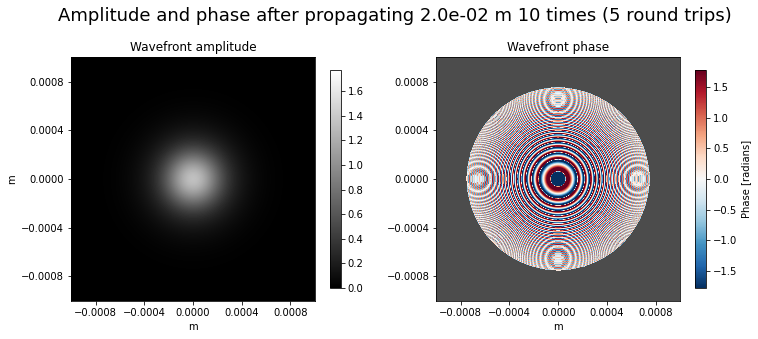

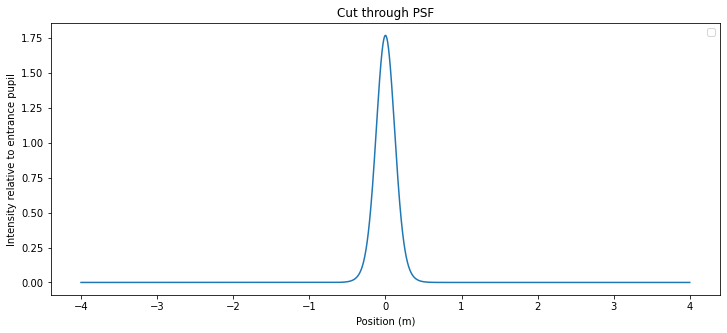

In [15]:
# 2D plot of electric field amplitude and phase after `num_iter` iterations
plt.figure(figsize=(12,5))
wf.display('both',colorbar=True)
plt.suptitle(
    f'Amplitude and phase after propagating {z.to("m"):.1e} {num_iter} times'
    +f' ({num_iter//2:d} round trips)',
    fontsize=18)

plt.figure(figsize=(12,5))
Y, X = wf.coordinates()
plt.plot(x, wf.intensity[ind_c, :])
plt.title('Cut through PSF')
plt.xlabel('Position (m)')
plt.ylabel('Intensity relative to entrance pupil')
plt.legend(loc='upper right')

Text(0, 0.5, 'Phase (deg)')

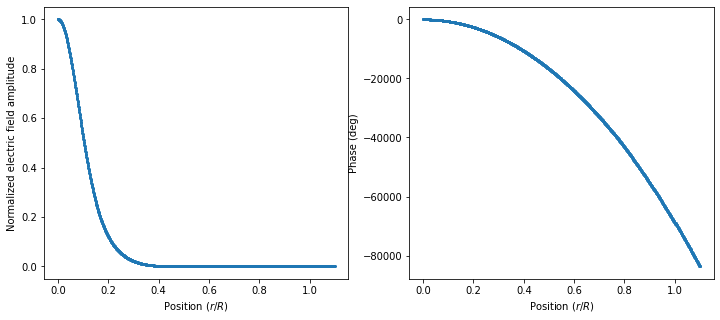

In [16]:
# 1D cut of electric field amplitude and phase after `num_iter` iterations
# (cf. Fig. 5/11 of FoxLi1961 for square/circular apertures)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = axs[0]
mask = (x >= 0) & (x <= 1.1*aperture_radius)
# Electric field amplitudee
y = np.abs(wf.wavefront[ind_c, mask])
# Intensity
# y = np.abs(wavefronts[i, ind_c, mask])**2    
axs[0].plot(
    x[mask]/aperture_radius, y/y.max(),
    marker='o', markersize=2)

# Phase of electric field (relative to value at origin)
y = np.rad2deg(np.unwrap(np.angle(wf.wavefront[ind_c, mask])))
axs[1].plot(
    x[mask]/aperture_radius, y-y[0],
    marker='o', markersize=2)
for ax in axs:
    ax.set_xlabel(r'Position ($r/R$)')
axs[0].set_ylabel('Normalized electric field amplitude')
axs[1].set_ylabel('Phase (deg)')

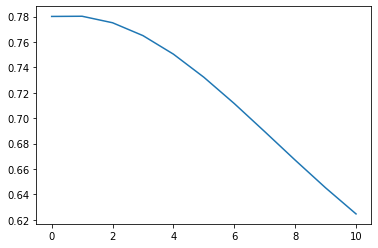

In [17]:
# Flucutation of normalized field amplitude at (x, y) position `(initial_gaussian_radius/2, 0)`
# as a function of number of iterations
x_c = initial_gaussian_radius/2
mask = hroundtrips > -1
ax = plt.gca()
ax.plot(
    np.arange(num_iter+1)[mask],
    np.abs(wavefront_cuts[mask, np.argmin(np.abs(x-x_c))])
    /np.abs(wavefront_cuts[mask, ind_c])
    )

In [18]:
# Eigenvalue of dominant mode
gamma = np.nanmean(wavefronts[-1]/wavefronts[-2])
# Phase of eigenvalue (deg) (additional round-trip phase)
# (cf. Fig. 9 of FoxLi1961)
gamma_phase = np.rad2deg(np.angle(gamma))
gamma_phase_ = np.rad2deg(np.angle((wavefronts[-1]*np.conjugate(wavefronts[-2])).sum()))
print(f'Half round-trip phase: {gamma_phase:.1f} deg')
print(f'{gamma_phase-gamma_phase_:.2e}')
# 1 - absolute square of eigenvalue (half round-trip diffraction losses)
# (cf. Fig. 8 of FoxLi1961)
hroundtrip_loss = 1-np.abs(gamma)**2
print(f'Half round-trip diffraction losses: {hroundtrip_loss:.2e}')

Half round-trip phase: 134.1 deg
-3.44e-01
Half round-trip diffraction losses: -1.39e-01


In [19]:
# Find total intensity of each iteration
# integrated_intensities = (np.abs(wavefronts)**2).sum(axis=(1, 2))

In [20]:
# Diffraction losses per half round trip (cf. Fig. 8 of FoxLi1961)
# mask = hroundtrips >= 1
# ax = plt.gca()
# ax.plot(hroundtrips[mask], integrated_intensities[mask]/integrated_intensities[mask][0])
# roundtrip_loss_func = lambda n, a: np.exp(-a*n)
# popt, pcov = scipy.optimize.curve_fit(
#     roundtrip_loss_func, np.arange(mask.sum()),
#     integrated_intensities[mask]/integrated_intensities[mask][0],
#     0.08)
# hroundtrip_loss_fit = popt[0]
# print(hroundtrip_loss_fit)
# plt.plot(
#     hroundtrips[mask], roundtrip_loss_func(np.arange(mask.sum()), *popt),
#     label=f'Loss per half round trip: {hroundtrip_loss_fit*1e2:.1e} %')
# ax.set_xlabel('Iteration (half round trip)')
# ax.set_ylabel('Integrated intensity')
# ax.legend()